In [1]:
import scanpy as sc
from pathlib import Path
from dask import array as da
from tqdm.dask import TqdmCallback

from utils.cellxgene import get_cxg_url
from scatlastb_utils.io import read_anndata, write_zarr_linked

/Users/michaela.mueller/miniforge3/envs/scanpy/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/michaela.mueller/miniforge3/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'Hrovatin2023'
file_path = f'data/{dataset_name}.h5ad'

In [3]:
output_dir = Path('data/output')
output_dir.mkdir(parents=True, exist_ok=True)

# Get data

In [4]:
url = get_cxg_url(
    collection_id="296237e2-393d-4e31-b590-b03f74ac5070",
    dataset_id="49e4ffcc-5444-406d-bdee-577127404ba8"
)

Get URL for CxG collection ID "296237e2-393d-4e31-b590-b03f74ac5070" and dataset ID "49e4ffcc-5444-406d-bdee-577127404ba8"
URL: https://datasets.cellxgene.cziscience.com/83fb4cdb-a14c-4a8a-88bb-4065835986dd.h5ad


In [5]:
# download only if the file does not exist
if not Path(file_path).exists():
    !curl {url} > {file_path}

In [6]:
adata = read_anndata(
    file_path,
    X='raw/X',
    obs='obs',
    var='var',
    obsm='obsm',
    obsp='obsp',
    dask=True,
    backed=True,
    stride=10_000,
)
adata

dask: True, backed: True
chunks: (10000, -1)
Read slot "raw/X", store as "X"...
Read raw/X as backed sparse dask array...
Read slot "obs", store as "obs"...
Read slot "var", store as "var"...
Read slot "obsm", store as "obsm"...


Read obsm slots as_dask=False: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 66.53it/s]

Read slot "obsp", store as "obsp"...
shape: (301796, 31202)


AnnData object with n_obs × n_vars = 301796 × 31202
    obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_scaled', 'cell_subtype_beta_coarse_reannotatedIntegrated', 'cell_subtype_beta_fine_reannotatedIntegrated', 'GP_1', 'GP_2', 'GP_3', 'GP_4', 'GP_5', 'GP_6', 'GP_7', 'GP_8', 'GP_9', 'GP_10', 'GP_11', 'GP_12', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_18', 'GP_19', 'GP_20', 'GP_21', 'GP_22', 'GP_23', 'GP_24', 'GP_25', 'GP_26', 'GP_27', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'diabetes_model', 'chemical_stress', 'GEO

## Visualise data

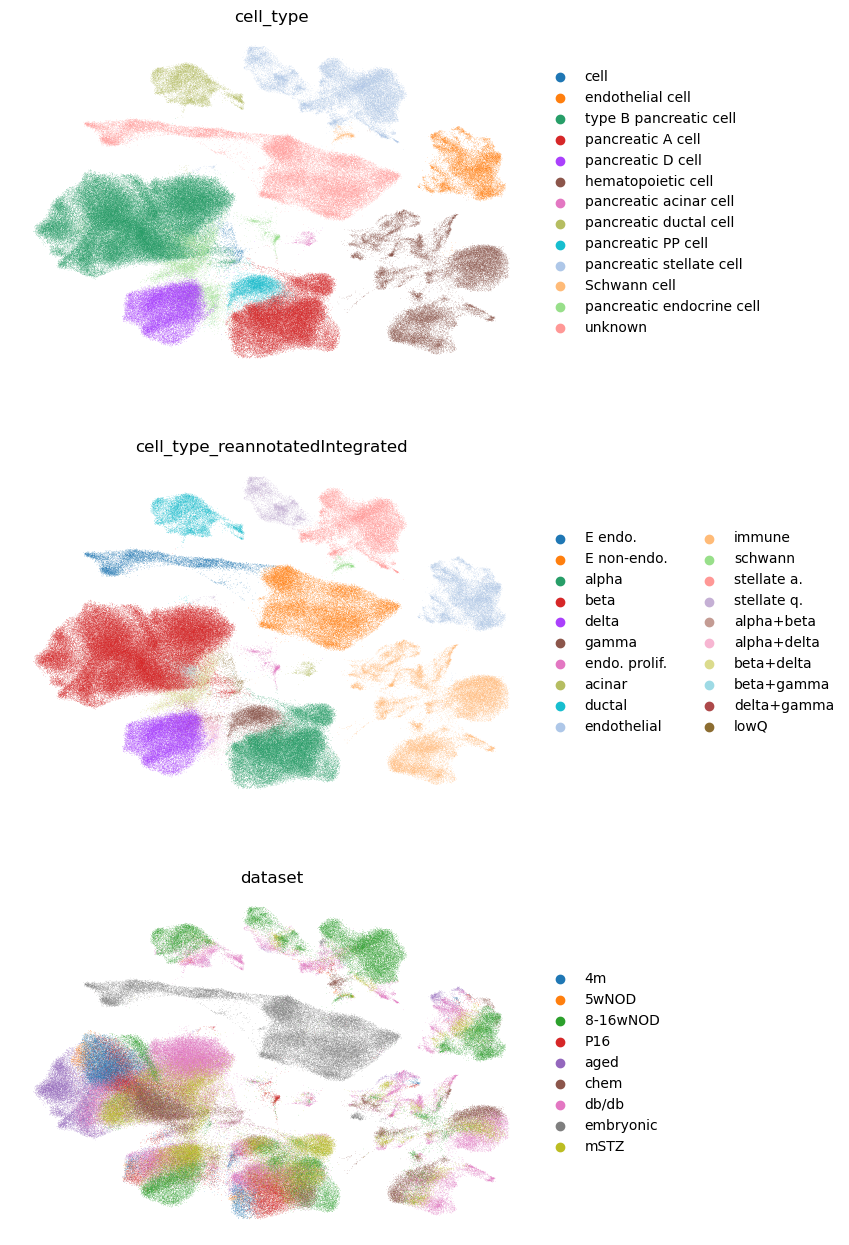

In [7]:
sc.pl.embedding(
    adata,
    'X_integrated_umap',
    color=['cell_type', 'cell_type_reannotatedIntegrated', 'dataset'],
    ncols=1,
    frameon=False,
)

In [8]:
%%time
adata.write_zarr(f'data/output/{dataset_name}.zarr')

CPU times: user 32.5 s, sys: 7.47 s, total: 40 s
Wall time: 49.8 s


# Preprocess data

In [9]:
layer = 'normcounts'

In [10]:
adata.layers[layer] = adata.X.copy()

In [11]:
# if isinstance(adata.X, da.Array):
#     with TqdmCallback(leave=False):
#         adata.X = adata.X.compute()

In [12]:
sc.pp.normalize_total(adata, layer=layer, target_sum=1e4)

In [13]:
sc.pp.log1p(adata, layer=layer)

In [14]:
%%time
sc.pp.highly_variable_genes(
    adata,
    layer=layer,
    n_top_genes=2000,
    # batch_key='dataset',
)

CPU times: user 32.5 s, sys: 4.96 s, total: 37.4 s
Wall time: 25.1 s


In [15]:
%%time
sc.pp.pca(
    adata,
    layer=layer,
    n_comps=50,
    mask_var='highly_variable',
)
adata.obsm['X_pca'] = adata.obsm['X_pca'].compute()

CPU times: user 1min 46s, sys: 13.4 s, total: 2min
Wall time: 52.9 s


In [16]:
%%time
sc.pp.neighbors(adata, use_rep='X_pca')

CPU times: user 43.8 s, sys: 2.32 s, total: 46.2 s
Wall time: 46 s


In [17]:
%%time
sc.tl.umap(adata)

CPU times: user 5min 43s, sys: 8.45 s, total: 5min 51s
Wall time: 2min 47s


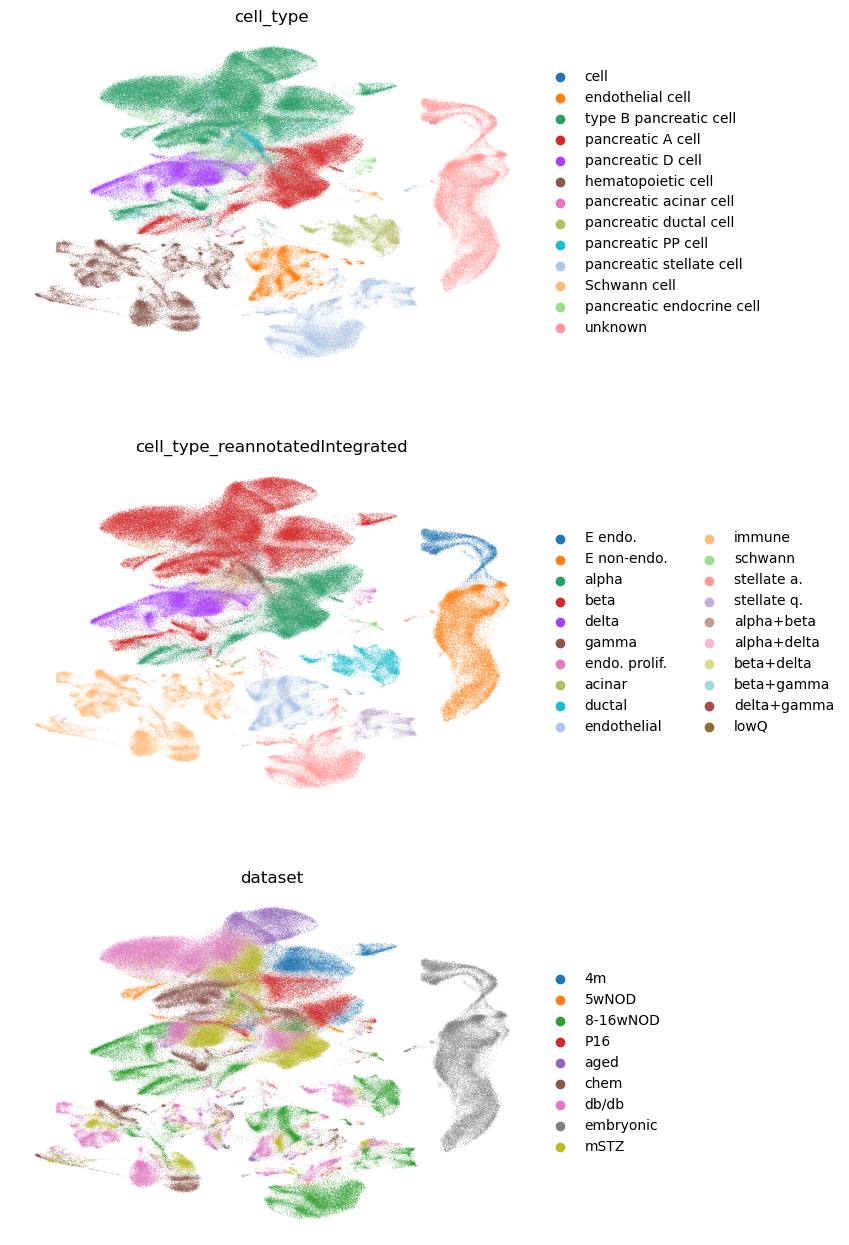

In [18]:
sc.pl.umap(
    adata,
    color=[
        'cell_type',
        'cell_type_reannotatedIntegrated',
        'dataset',
    ],
    ncols=1,
    frameon=False,
)

In [19]:
write_zarr_linked(
    adata,
    in_dir=f'data/output/{dataset_name}.zarr',
    out_dir=f'data/{dataset_name}_preprocessed.zarr',
    files_to_keep=['X', 'layers', 'obsm', 'obsp', 'var', 'varm'],
)

remove slot to be linked: varp
remove slot to be linked: uns
remove slot to be linked: obs
remove slot to be linked: X
slot_map: [('.zattrs', '.zattrs'),
 ('.zgroup', '.zgroup'),
 ('obs', 'obs'),
 ('varp', 'varp'),
 ('uns', 'uns'),
 ('X', 'X')]
Link /.zattrs -> /.zattrs
Link /.zgroup -> /.zgroup
Link /obs -> /obs
replace data/Hrovatin2023_preprocessed.zarr/obs...
Link /varp -> /varp
replace data/Hrovatin2023_preprocessed.zarr/varp...
Link /uns -> /uns
replace data/Hrovatin2023_preprocessed.zarr/uns...
Link /X -> /X
